# Examples of neural reparamterization for structural optimization

In [the paper](https://arxiv.org/abs/1909.04240), we run every optimization for 1000 steps and focus on the largest problems. These are pretty slow to run, so to keep this notebook interactive we'll focus on smaller examples trained for fewer steps.

In [0]:
# Install dependencies with pip. Only run this once.
! pip install -q tf-nightly git+https://github.com/google-research/neural-structural-optimization.git

In [0]:
# Copyright 2019 Google LLC.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from IPython import display
from PIL import Image
import seaborn
import matplotlib.pyplot as plt
import xarray
import pandas as pd

from neural_structural_optimization import pipeline_utils
from neural_structural_optimization import problems
from neural_structural_optimization import models
from neural_structural_optimization import api
from neural_structural_optimization.train import (
    Adam_Optimizer, LBFGS_Optimizer, MMA_Optimizer, OptimalityCriteria_Optimizer
)

In [0]:
def train_all(problem, max_iterations, cnn_kwargs=None):
    args = api.specified_task(problem)
    if cnn_kwargs is None:
        cnn_kwargs = {}

    model = models.PixelModel(args=args)
    ds_mma = MMA_Optimizer(model, max_iterations).optimize()

    model = models.PixelModel(args=args)
    ds_oc = train.optimality_criteria(model, max_iterations)

    model = models.PixelModel(args=args)
    ds_pix = train.train_lbfgs(model, max_iterations)

    model = models.CNNModel(args=args, **cnn_kwargs)
    ds_cnn = train.train_lbfgs(model, max_iterations)

    dims = pd.Index(['cnn-lbfgs', 'mma', 'oc', 'pixel-lbfgs'], name='model')
    return xarray.concat([ds_cnn, ds_mma, ds_oc, ds_pix], dim=dims)

## MBB Beam (Figure 2 from paper)

Note that we tweaked the CNN model slightly original version of the paper, which results in a slightly worse design in this particular case.

See the updated figure in our [latest revision](https://openreview.net/forum?id=Bkec3m3q8B) on OpenReview.net.

In [4]:
problem = problems.mbb_beam(height=20, width=60)
max_iterations = 200

# can't upscale by exactly 8x for a 60x20 design region, so upscale by
# only 4x instead
%time ds = train_all(problem, max_iterations, cnn_kwargs=dict(resizes=(1, 1, 2, 2, 1)))

/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/autograd/numpy/numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


CPU times: user 1min 30s, sys: 31.4 s, total: 2min 1s
Wall time: 1min 18s


In [5]:
ds

<xarray.Dataset>
Dimensions:  (model: 4, step: 201, x: 60, y: 20)
Coordinates:
  * step     (step) int64 0 1 2 3 4 5 6 7 8 ... 193 194 195 196 197 198 199 200
  * model    (model) object 'cnn-lbfgs' 'mma' 'oc' 'pixel-lbfgs'
Dimensions without coordinates: x, y
Data variables:
    loss     (model, step) float64 1.825e+03 1.245e+03 1.919e+04 ... 237.9 237.9
    design   (model, step, y, x) float64 0.6222 0.7423 0.8178 ... 1.0 1.0 1.0

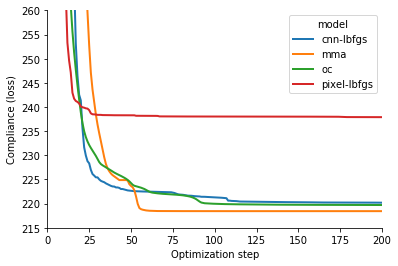

In [6]:
ds.loss.transpose().to_pandas().cummin().loc[:200].plot(linewidth=2)
plt.ylim(215, 260)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')
seaborn.despine()

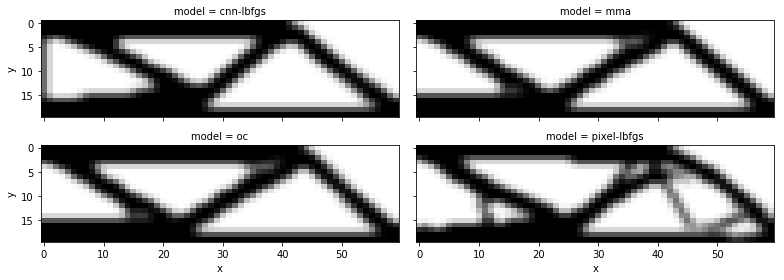

In [7]:
ds.design.sel(step=200).plot.imshow(
    col='model', x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys')

If desired, designs can also be converted into `PIL.Image` objects with the `pipeline_utils.image_from_design` utility. This is convenient for exporting single frames or creating GIFs:

In [0]:
def save_gif_movie(images, path, duration=200, loop=0, **kwargs):
    images[0].save(path, save_all=True, append_images=images[1:],
                   duration=duration, loop=loop, **kwargs)

In [0]:
images = [
    pipeline_utils.image_from_design(design, problem)
    for design in ds.design.sel(model='cnn-lbfgs')[:100]
]

In [0]:
save_gif_movie([im.resize((5*120, 5*20)) for im in images], 'movie.gif')

This produces the following movie of the optimization process:

<img src="https://github.com/google-research/neural-structural-optimization/raw/master/notebooks/movie.gif" />

## MBB beam with a larger grid

In [11]:
problem = problems.PROBLEMS_BY_NAME['mbb_beam_192x64_0.4']
max_iterations = 100
%time ds = train_all(problem, max_iterations)

/usr/local/lib/python3.6/dist-packages/autograd/numpy/numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)


CPU times: user 8min 28s, sys: 4min 14s, total: 12min 43s
Wall time: 7min 9s


Now, the CNN-LBFGS model performs best:

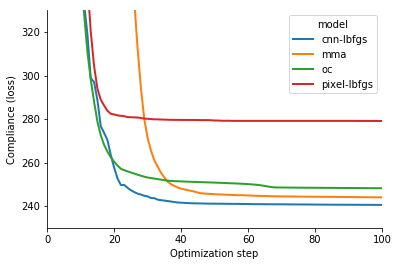

In [12]:
ds.loss.transpose().to_pandas().cummin().loc[:200].plot(linewidth=2)
plt.ylim(230, 330)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')
seaborn.despine()

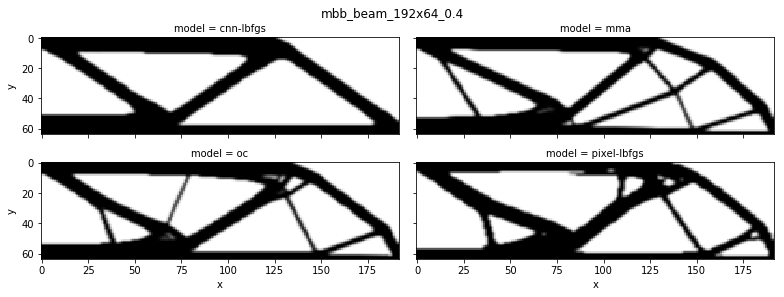

In [13]:
# the pixel-lbfgs does not run for the full 100 steps (it terminates
# early due to reaching a local minima), so use fill() to forward fill
# to the last valid design.
ds.design.ffill('step').sel(step=100).plot.imshow(
    col='model', x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys')
plt.suptitle(problem.name, y=1.02);

## Multistory building

In [14]:
problem = problems.PROBLEMS_BY_NAME['multistory_building_64x128_0.4']
max_iterations = 100  # keep things fast
%time ds = train_all(problem, max_iterations)

CPU times: user 5min 46s, sys: 2min 57s, total: 8min 44s
Wall time: 4min 53s


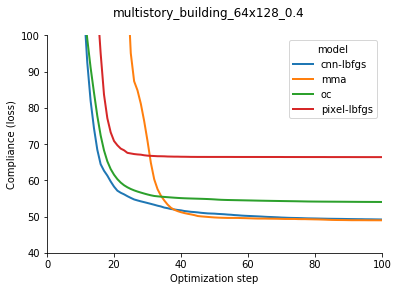

In [15]:
ds.loss.transpose().to_pandas().cummin().loc[:100].plot(linewidth=2)
plt.ylim(40, 100)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')
seaborn.despine()
plt.suptitle(problem.name);

For fun, we'll examine designs at different time-steps.

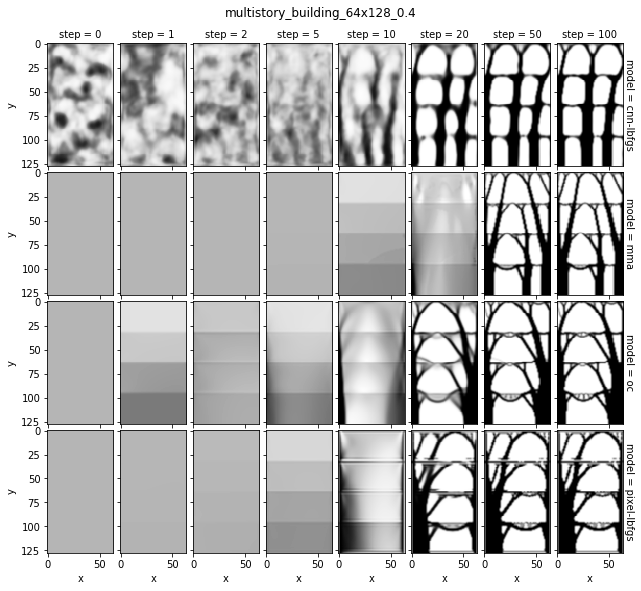

In [16]:
ds.design.sel(step=[0, 1, 2, 5, 10, 20, 50, 100]).plot.imshow(
    row='model', col='step', x='x', y='y', size=2, aspect=0.5,
    yincrease=False, add_colorbar=False, cmap='Greys')
plt.subplots_adjust(wspace=0.1, hspace=0.05)
plt.suptitle(problem.name, y=1.02);

## Thin support bridge

In [17]:
# we really need more iterations to see the CNN-LBFGS method dominate
problem = problems.PROBLEMS_BY_NAME['thin_support_bridge_128x128_0.2']
max_iterations = 200
%time ds = train_all(problem, max_iterations)

/usr/local/lib/python3.6/dist-packages/neural_structural_optimization/autograd_lib.py:102: RuntimeWarning: divide by zero encountered in true_divide
  weights = 1 / raw_filters.sum(axis=0).squeeze()


CPU times: user 26min 12s, sys: 12min 43s, total: 38min 55s
Wall time: 21min 39s


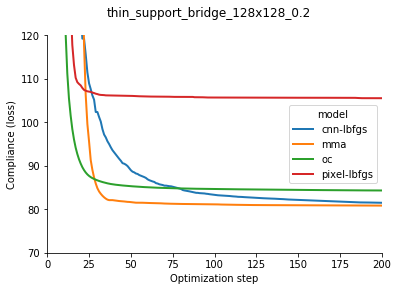

In [18]:
ds.loss.transpose().to_pandas().cummin().plot(linewidth=2)
plt.ylim(70, 120)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')
seaborn.despine()
plt.suptitle(problem.name);

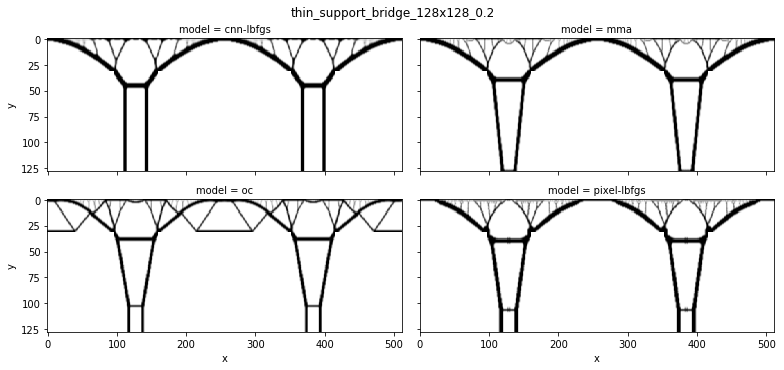

In [19]:
(xarray.concat([ds.design, ds.design.sel(x=slice(None, None, -1))] * 2, dim='x')
 .sel(step=200)
 .plot.imshow(
    col='model', x='x', y='y', size=2.5, aspect=2, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys'))
plt.suptitle(problem.name, y=1.02);